# Table Of Contents
* ## Importing Contents
* ## Basic Cleaning
* ## Basic Exploration
* ## Advanced Cleaning
* ## Exploratory Data Analysis
* ## Machine Laarning

#**Importing Modules**

In [4]:
!pip install tqdm

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from time import sleep
ROOT = "/content"
from tqdm import tqdm
import json

# **Spotify API**

We first obtain our raw data from the spotify million playlist dataset:
https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge

The raw dataset provides the basic details of tracks on spotify, such as name, artist and identification (URI). We extract a few slices from the entire dataset (~60,000 songs) and upload them to google colab

In [ ]:
!pip install spotipy==2.16

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!unzip mpd.slice2.zip

Next, we import the spotipy library to interect with the spotify API directly from google colab. This allows us to send the spotify API requests, and extract the song-specific details for our machine learning algorithms

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id="5fa1b1f372a54022be85dbdaaa792649", client_secret="84f297f748304b5c9a616c85b0139fb9")
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
def get_URI(link):
  return link.split("/")[-1].split("?")[0]

In [ ]:
df = pd.DataFrame()

In [ ]:
for i in range(1,7):
  file = "mpd.slice.{}.json".format(i)
  print("Processing "+ file)
  with open(file) as train_file:
      dictionary = json.load(train_file)
      
  playlists = [x["tracks"] for x in dictionary["playlists"]]
  tracks = [x["track_uri"] for playlist in playlists for x in playlist]


  for i in tqdm(range(0,len(tracks)-50, 50)):
    part = tracks[i:i+50]
    try:
      part_data = sp.audio_features(part)
      part_info = sp.tracks(part)['tracks']

      part_artists_info = sp.artists([artist['artists'][0]['id'] for artist in part_info])["artists"]
      part_artist = [artist["name"] for artist in part_artists_info]
      part_genre = ["/".join(artist["genres"]) for artist in part_artists_info]

      part_df = pd.concat([pd.DataFrame(part_data).drop(["id","uri","track_href","analysis_url"],axis=1), pd.DataFrame(part_info)[["name","popularity"]]],axis=1)
      part_df["artist"] = part_artist
      part_df["genre"] = part_genre

      df = pd.concat([df, part_df])

    except:
      pass



In [ ]:
df.to_csv("spotify_dataset.csv")

# **Importing the dataset**

Here, we upload our extracted data and display it to get a general understanding of it

In [ ]:
# Upload "spotify_dataset.csv"
from google.colab import files
files.upload()

In [8]:
df = pd.read_csv("spotify_dataset.csv")
df.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,name,popularity,artist,genre
0,0,0.723,0.809,7,-3.081,0,0.0625,0.00346,0.00123,0.5650,0.2740,98.007,audio_features,176561,4,Lean On (feat. MØ & DJ Snake),0,Major Lazer,dance pop/edm/electro house/moombahton/pop/pop...
1,5,0.642,0.734,2,-3.924,1,0.0300,0.07590,0.00000,0.0937,0.9030,155.031,audio_features,171707,4,Cut Me Some Slack,0,Chris Janson,contemporary country/country/country road/mode...
2,0,0.419,0.793,2,-6.131,0,0.1250,0.00857,0.03570,0.4140,0.0712,127.944,audio_features,406907,4,Raining (feat. SunSun) - Dance Love Edit,0,Kaskade,edm/electro house/pop dance/progressive house/...
3,47,0.622,0.735,11,-7.538,0,0.0408,0.22500,0.46400,0.1380,0.1170,126.979,audio_features,219253,3,4 AM - Adam K & Soha Radio Edit,0,Kaskade,edm/electro house/pop dance/progressive house/...
4,8,0.615,0.758,6,-5.024,1,0.0320,0.06670,0.00000,0.1990,0.5410,106.904,audio_features,183760,4,Georgia Clay,0,Josh Kelley,acoustic pop/indiecoustica/neo mellow


In [9]:
# Drop irrelevant columns
df = df.drop(["Unnamed: 0",'type','time_signature'],axis=1)

In [10]:
df.info()
print("There are {} unique titles, {} unique artists, and {} unique genres".format(len(df.name.unique()),
                                                                                   len(df.artist.unique()), 
                                                                                   len(df.genre.unique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63032 entries, 0 to 63031
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      63032 non-null  float64
 1   energy            63032 non-null  float64
 2   key               63032 non-null  int64  
 3   loudness          63032 non-null  float64
 4   mode              63032 non-null  int64  
 5   speechiness       63032 non-null  float64
 6   acousticness      63032 non-null  float64
 7   instrumentalness  63032 non-null  float64
 8   liveness          63032 non-null  float64
 9   valence           63032 non-null  float64
 10  tempo             63032 non-null  float64
 11  duration_ms       63032 non-null  int64  
 12  name              63031 non-null  object 
 13  popularity        63032 non-null  int64  
 14  artist            63032 non-null  object 
 15  genre             58497 non-null  object 
dtypes: float64(9), int64(4), object(3)
memor

##**Label References**


title - name of the song

artist - artist of the song

genre - the genre of the track

year - the release year of the recording. (may be unreliable due to re-releases and reuploads)

bpm (beats per minute) - The tempo of the song.

energy - The energy of a song - the higher the value, the more energtic

dance - The higher the value, the easier it is to dance to

volume (dB) - The higher the value, the louder the song

live - The higher the value, the more likely the song is a live recording.

valence - The higher the value, the more positive mood for the song.

length - The duration of the song.

acous (acoustics) - The higher the value the more acoustic the song is.

speech (speechiness) - The higher the value the more spoken word the song 

pop (popularity) - The higher the value the more popular the song is.

# **Basic Cleaning**

We proceed to do basic cleaning of the data such as handling NaN values and duplicates. This ensures that our models can be trained without skewed data

## Handling NaN values

In [11]:
# Check for NaN values in the dataset
df[df.isna().any(axis=1)].head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,name,popularity,artist,genre
11,0.606,0.789,10,-6.645,1,0.1640,0.0101,0.0088,0.1260,0.0775,128.452,353891,Raining - Extended,0,Kaskade & Adam K feat. Sunsun,NaN
40,0.656,0.641,5,-4.121,0,0.0543,0.2850,0.0257,0.3280,0.9290,202.042,212193,El Baile Del Gorila,0,Grupo Massore,NaN
44,0.709,0.705,0,-8.503,1,0.2730,0.5500,0.0000,0.3190,0.7380,175.856,272300,Ella Y Yo,0,Reggaetones,NaN
95,0.803,0.636,10,-6.004,1,0.3070,0.1070,0.0000,0.0903,0.3240,140.006,219840,In The Nights,0,Damion,NaN
97,0.884,0.296,4,-11.212,0,0.2700,0.5780,0.0000,0.1380,0.2830,132.953,218359,I Beat My Meat,0,Thanks Ugly God,NaN


Observation: Looks like most of the NaN comes from the genre column

In [12]:
# Check for NaN that isn't under genre
df[df.drop("genre",axis=1).isna().any(axis=1)].head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,name,popularity,artist,genre
3646,0.771,0.395,4,-9.514,0,0.0378,0.0561,0.0,0.122,0.149,112.013,205558,NaN,0,Various Artists,NaN


In [13]:
# Remove NaN rows (excluding those in genre)

df = df.dropna(how='any', subset=['danceability',	'energy',	'key', 'loudness',	'mode',	'speechiness',	'acousticness',	'instrumentalness',	'liveness',	'valence',	'tempo',	'duration_ms',	'name',	'popularity',	'artist'])
df


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,name,popularity,artist,genre
0,0.723,0.809,7,-3.081,0,0.0625,0.00346,0.001230,0.5650,0.2740,98.007,176561,Lean On (feat. MØ & DJ Snake),0,Major Lazer,dance pop/edm/electro house/moombahton/pop/pop...
1,0.642,0.734,2,-3.924,1,0.0300,0.07590,0.000000,0.0937,0.9030,155.031,171707,Cut Me Some Slack,0,Chris Janson,contemporary country/country/country road/mode...
2,0.419,0.793,2,-6.131,0,0.1250,0.00857,0.035700,0.4140,0.0712,127.944,406907,Raining (feat. SunSun) - Dance Love Edit,0,Kaskade,edm/electro house/pop dance/progressive house/...
3,0.622,0.735,11,-7.538,0,0.0408,0.22500,0.464000,0.1380,0.1170,126.979,219253,4 AM - Adam K & Soha Radio Edit,0,Kaskade,edm/electro house/pop dance/progressive house/...
4,0.615,0.758,6,-5.024,1,0.0320,0.06670,0.000000,0.1990,0.5410,106.904,183760,Georgia Clay,0,Josh Kelley,acoustic pop/indiecoustica/neo mellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63027,0.872,0.391,0,-9.144,0,0.2420,0.46900,0.000004,0.2970,0.4370,134.021,119133,Jocelyn Flores,89,XXXTENTACION,emo rap/miami hip hop
63028,0.527,0.835,6,-5.298,1,0.0433,0.01660,0.000000,0.2490,0.6540,125.983,176658,The Nights,89,Avicii,dance pop/edm/pop/pop dance
63029,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.000000,0.0454,0.7600,104.504,284200,The Real Slim Shady,91,Eminem,detroit hip hop/hip hop/rap
63030,0.603,0.783,6,-4.023,1,0.0620,0.44900,0.000008,0.1190,0.7750,172.041,173104,Dark Red,91,Steve Lacy,afrofuturism/pop


Observation: Only one row with NaN values (not from genre column)

Before removal = 63032 rows\
After removeal = 63031 rows

## Handling duplicates

In [14]:
# sort df by popularity
df = df.sort_values("popularity", ascending=True)

# Remove duplicate track titles, keeps row with highest pop value
df = df[df.duplicated('name', keep="first") == False]
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,name,popularity,artist,genre
0,0.723,0.809,7,-3.081,0,0.0625,0.00346,0.001230,0.5650,0.274,98.007,176561,Lean On (feat. MØ & DJ Snake),0,Major Lazer,dance pop/edm/electro house/moombahton/pop/pop...
14473,0.861,0.742,0,-6.145,1,0.0582,0.08290,0.000000,0.0921,0.961,131.615,236507,Take the Fifth,0,Spoon,alternative rock/austindie/indie pop/indie roc...
14472,0.452,0.686,11,-9.165,1,0.0616,0.01870,0.000411,0.0731,0.116,178.112,180440,Advance Cassette,0,Spoon,alternative rock/austindie/indie pop/indie roc...
14471,0.574,0.833,1,-8.255,0,0.0441,0.68400,0.353000,0.0862,0.426,114.018,291627,Reichpop,0,Wild Nothing,chillwave/dream pop/dreamo/electropop/indie ro...
14470,0.498,0.857,7,-5.771,1,0.0631,0.28100,0.000070,0.0671,0.179,121.568,197453,Trigger Cut / Wounded Kite at :17,0,Pavement,alternative rock/anti-folk/art rock/dream pop/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63027,0.872,0.391,0,-9.144,0,0.2420,0.46900,0.000004,0.2970,0.437,134.021,119133,Jocelyn Flores,89,XXXTENTACION,emo rap/miami hip hop
63028,0.527,0.835,6,-5.298,1,0.0433,0.01660,0.000000,0.2490,0.654,125.983,176658,The Nights,89,Avicii,dance pop/edm/pop/pop dance
63030,0.603,0.783,6,-4.023,1,0.0620,0.44900,0.000008,0.1190,0.775,172.041,173104,Dark Red,91,Steve Lacy,afrofuturism/pop
63029,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.000000,0.0454,0.760,104.504,284200,The Real Slim Shady,91,Eminem,detroit hip hop/hip hop/rap


#**Basic Exploration**

After cleaning, we start do perform basic exploratory data analysis on the numerical and categorical data. From there, we get a rough understanding of the overall distribution and allows us to continue with more advanced data cleaning and feature engineering

In [15]:
# split columns into categorical and numerical data types
categorical = ["artist",'genre']
numerical = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms','popularity']

## Numerical Data

In [16]:
# Plot box-plot, histogram and violin plot for all the numerical data
def plot_numericals(dataframe):
  f, axes = plt.subplots(len(numerical), 3, figsize=(20, 13), constrained_layout = True)
  for i,num in enumerate(tqdm(numerical)):
    data = pd.DataFrame(dataframe[num])
    sb.boxplot(data = data, orient = "h", ax = axes[i,0],color="green")
    sb.histplot(data = data, ax = axes[i,1],color="blue")
    sb.violinplot(data = data, orient = "h", ax = axes[i,2],color="yellow")

In [ ]:
# Check the distribution for each of the numerical values
plot_numericals(df)

Observations:
1. Most values are in range 0-1, with exception of loudness in the negative range
2. There is a disproportionate number of tracks with 0 popularity
3. Something amiss with instrumentalness column

### **Do some random checks on the 0 popularity songs and see whether they can be removed**

->Insert photo or something

## Categorical Data

In [18]:
# View the different values in artist column
df["artist"].value_counts()

Streets                  157
Eminem                   136
Pearl Jam                128
Dave Matthews Band       103
Rascal Flatts            102
                        ... 
Los Leones Del Norte       1
Alagoas                    1
The Low Life               1
Boston Pops Orchestra      1
Offset                     1
Name: artist, Length: 16964, dtype: int64

Observation: There are 16964 unique artists, the variety in artists may prove to be ineffective in training our predictive model

In [19]:
# View the different values in genre column
df["genre"].value_counts()[:20]

contemporary country/country/country road                                             541
contemporary country/country/country road/modern country rock                         406
dance pop/pop/post-teen pop                                                           376
dance pop/pop                                                                         186
beats                                                                                 172
grunge/permanent wave/rock                                                            159
adult standards/easy listening/lounge                                                 155
modern rock/rock                                                                      152
ccm/christian alternative rock/christian music/world worship/worship                  149
k-pop/k-pop boy group                                                                 145
reggae fusion                                                                         143
latin/lati

Observation: the genres are a mix of multiple subgenres, data preprocessing required to make use of this categorical value

In [20]:
# Explore and find the most frequent genres
df["genre"].nunique()

9338

Each song can be tagged with multiple genres. Our team decided to reduce the dimensionality of genres by collating the most frequently occuring genres

In [21]:
# Split the combined genres into their individual categories
dfcpy=df["genre"].str.split(r"/", expand=True)
# Concat all genre instances into 1 dataframe to track their frequency
test = pd.DataFrame(pd.concat([pd.DataFrame(dfcpy[i]).value_counts() for i in range(18)],axis=0),columns=["freq"]).reset_index()

In [22]:
# Sort by frequency and get the most frequent genres
test=test.sort_values("freq",ascending=False)
test.columns=["genre",'freq']

In [23]:
test=test.groupby(by=["genre"]).sum().sort_values("freq",ascending=False)
genres = test.index.tolist()[:25]
genres.reverse()

In [24]:
genres

['classic rock',
 'post-teen pop',
 'electro house',
 'electropop',
 'stomp and holler',
 'pop dance',
 'urban contemporary',
 'alternative rock',
 'indie rock',
 'gangster rap',
 'country road',
 'r&b',
 'contemporary country',
 'southern hip hop',
 'country',
 'trap',
 'edm',
 'modern rock',
 'pop rock',
 'hip hop',
 'pop rap',
 'rap',
 'rock',
 'dance pop',
 'pop']

We now have a list of the top 25 most frequent genres (least to most frequent)

#**Advanced Cleaning**

## Numerical Data

Looking at the primary EDA, we decide to normalize the data so everything is represented on a scale of 0-1. We also decided to remove songs with 0 popularity because there is a disproportionate amount of them, and they are songs which have minimal plays on spotify

In [25]:
# Create a copy
df_clean = df.copy()
# Remove tracks with 0 popularity
df_clean = df_clean[df_clean["popularity"]>0]
#df_clean['popularity']

In [26]:
# Normalize the data using min-max so each numerical value is between 0-1
def normalize(dataframe):
  dataframe[numerical] = (dataframe[numerical] - dataframe[numerical].min()) / (dataframe[numerical].max() - dataframe[numerical].min())
normalize(df_clean)

In [27]:
df_clean["instrumentalness"].describe()

count    41330.000000
mean         0.097538
std          0.247299
min          0.000000
25%          0.000000
50%          0.000013
75%          0.005548
max          1.000000
Name: instrumentalness, dtype: float64

In [28]:
# Instrumentalness column is positively skewed, so perform squareroot transformation
df_clean["instrumentalness"] = np.sqrt(df_clean["instrumentalness"])
df_clean['popularity']

22122    0.000000
22123    0.000000
22124    0.000000
22125    0.000000
22126    0.000000
           ...   
63027    0.956522
63028    0.956522
63030    0.978261
63029    0.978261
63031    1.000000
Name: popularity, Length: 41330, dtype: float64

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


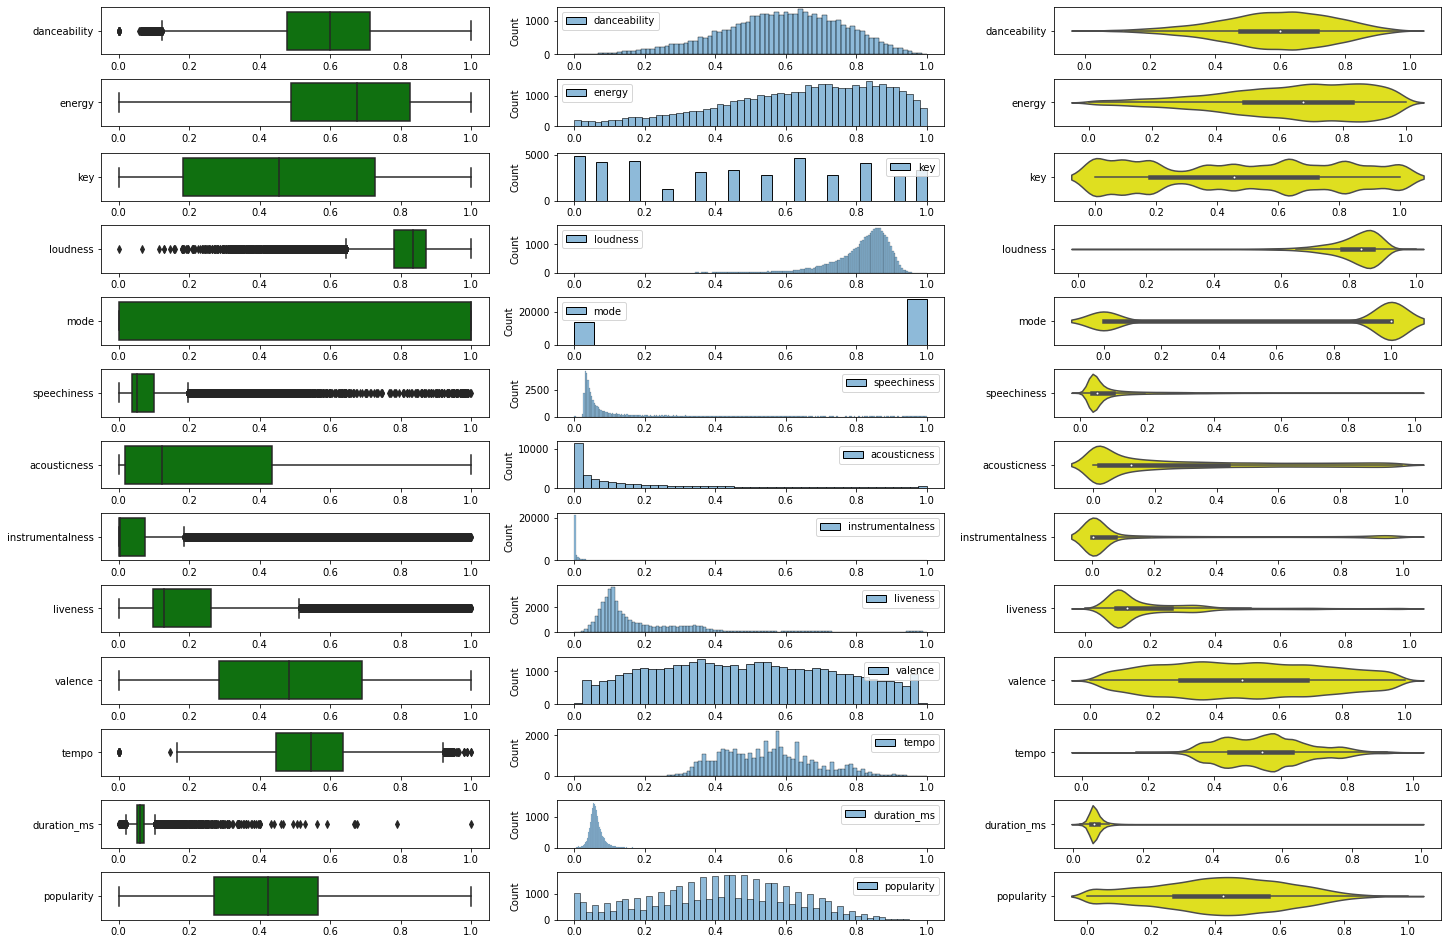

In [29]:
plot_numericals(df_clean)

## Categorical Data

Based on our previous genre EDA, we clean out NA values in genre, and filter all tracks that are part of the top 25 most frequent genres.

In [30]:
# Fill NA values as "no genre"
df_clean['genre'] = df_clean['genre'].fillna('no genre')

In [31]:
# Simplify genres and add them as an individual column

for genre in genres:
  df_clean["genre"][df_clean['genre'].str.contains(genre, case=True, na=False)] = genre.upper()
genres = [genre.upper() for genre in genres]
df_clean = df_clean.loc[df_clean['genre'].isin(genres)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
df_clean["genre"].value_counts()

POP                     3528
ROCK                    3325
ALTERNATIVE ROCK        2331
HIP HOP                 1918
COUNTRY ROAD            1727
GANGSTER RAP            1521
URBAN CONTEMPORARY      1412
CLASSIC ROCK            1409
POST-TEEN POP           1350
TRAP                    1287
STOMP AND HOLLER        1137
ELECTRO HOUSE           1077
ELECTROPOP              1073
POP ROCK                1009
R&B                      883
SOUTHERN HIP HOP         782
RAP                      771
COUNTRY                  717
MODERN ROCK              583
INDIE ROCK               384
DANCE POP                346
POP RAP                  339
POP DANCE                334
EDM                      291
CONTEMPORARY COUNTRY     238
Name: genre, dtype: int64

# **Exploratory data analysis**

After cleaning our data, we can perform exploratory data analysis to find any correlations in our data. For this project, we wish to train a model to predict whether a song will be popular or not, hence we decided to convert the numerical popularity label into binary "pop" and "not pop".

In [33]:
df_pop = df_clean.copy()

names = ["Not pop", "pop"]
df_pop['pop'] = pd.qcut(df_pop['popularity'],
                              q=[0, .9, 1],
                              labels=names)
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29772 entries, 22122 to 63031
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   danceability      29772 non-null  float64 
 1   energy            29772 non-null  float64 
 2   key               29772 non-null  float64 
 3   loudness          29772 non-null  float64 
 4   mode              29772 non-null  float64 
 5   speechiness       29772 non-null  float64 
 6   acousticness      29772 non-null  float64 
 7   instrumentalness  29772 non-null  float64 
 8   liveness          29772 non-null  float64 
 9   valence           29772 non-null  float64 
 10  tempo             29772 non-null  float64 
 11  duration_ms       29772 non-null  float64 
 12  name              29772 non-null  object  
 13  popularity        29772 non-null  float64 
 14  artist            29772 non-null  object  
 15  genre             29772 non-null  object  
 16  pop               

## Graph plots

Plot a heatmap to check linear correlations between labels

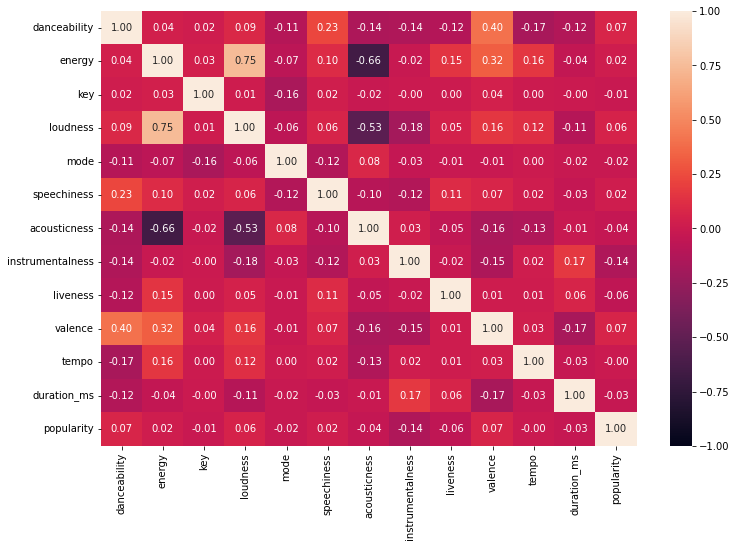

In [34]:
# Find correlation coefficient between numerical values and popularity
def plot_heatmap(dataframe):
  f = plt.figure(figsize=(12, 8))
  sb.heatmap(dataframe[numerical].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")
plot_heatmap(df_pop)

At a glance, there ae high correlations between loudness, energy and acousticness. However, popularity does not seem to have high linear correlations with any of the labels. The highest correlation observed is -0.14 between popularity and instrumentalness and is considered a weak correlation

Next, we plot boxplots of the labels to explore the categorical relationship with popualarity

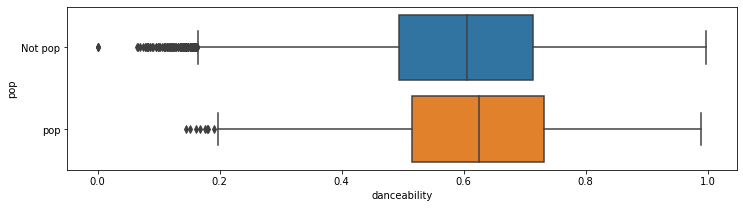

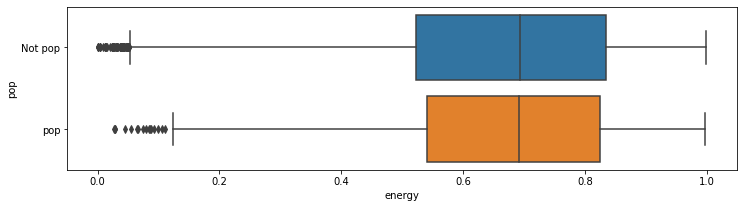

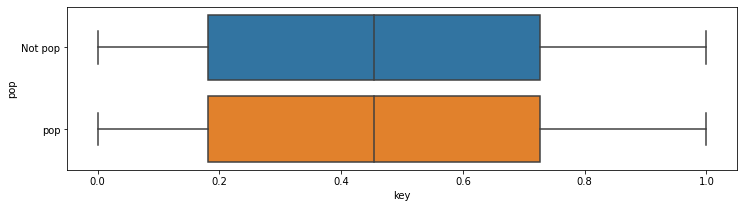

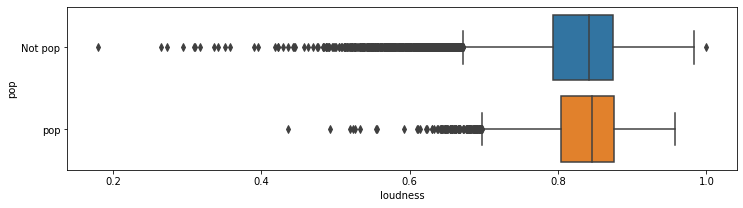

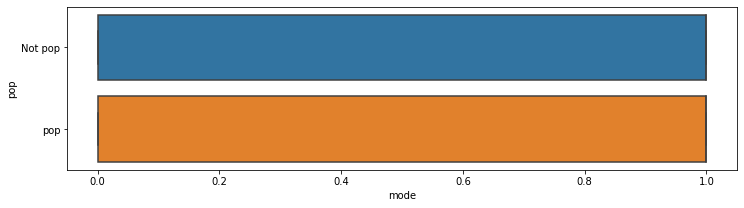

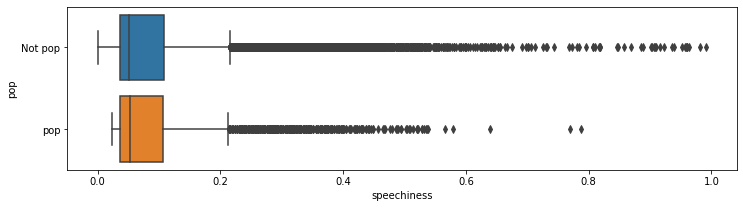

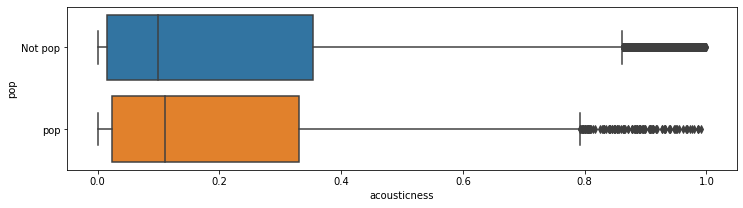

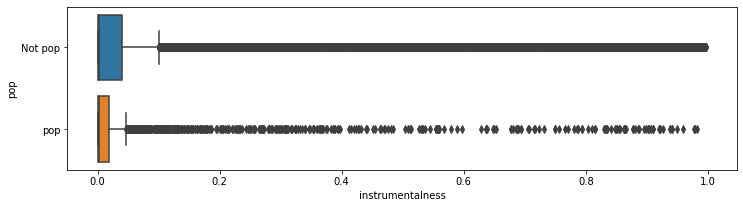

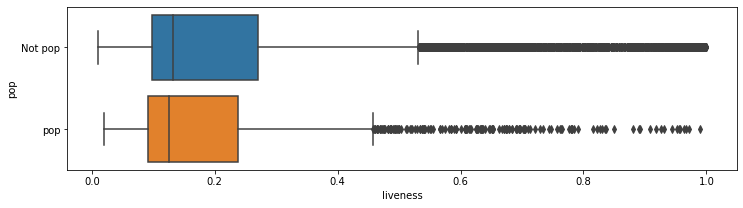

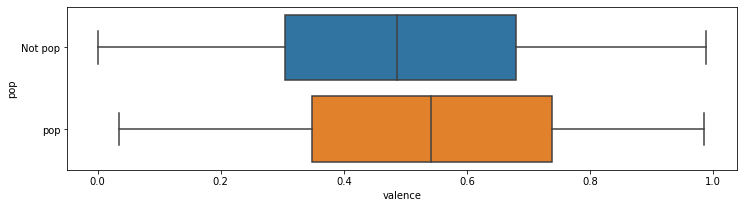

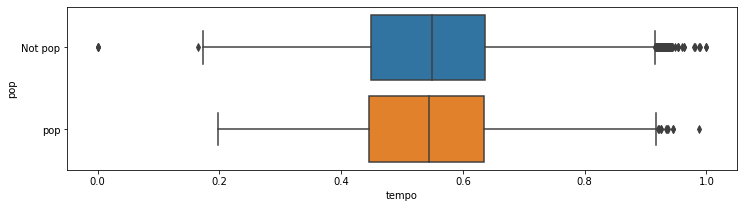

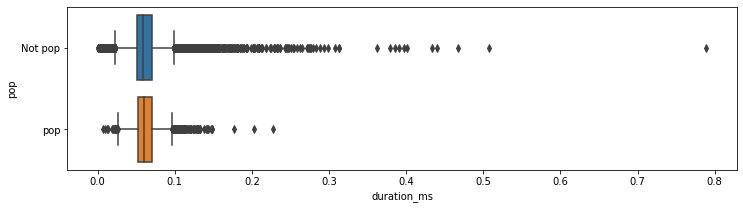

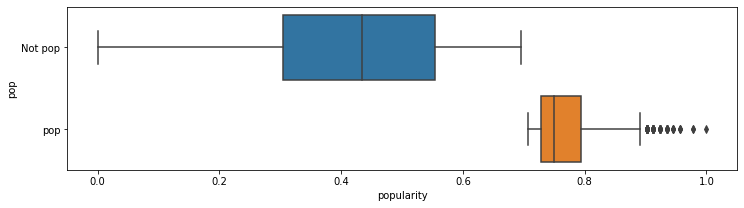

In [35]:
def plot_boxplot(dataframe, metric="pop"):

  for i, num in enumerate(numerical):
    f = plt.figure(figsize=(12, 3))
    sb.boxplot(x = num, y = metric, data = dataframe, orient = "h")

plot_boxplot(df_pop)

We observed that most of the labels do not provide clear distinction between them and the song's popularity. This leads us to the hypothesis that multiple variables are needed to determine a song's popularity

To get a better visualization, we used a pairplot to check the distribution of popular and unpopular songs with reference to their individual labels

In [ ]:
# Refer to pairplot folder for image
sb.pairplot(data = df_pop,hue="pop")

Overall, there does not seem to be a clear distinction between popularity and any one variable. But labels such as duration and loudness suggest that popular songs vary less compared to their unpopular counterparts

Another visualization we did was to plot the top generes with reference to the labels.

In [ ]:
# Refer to pairplot folder for image
sb.pairplot(data = df_pop,hue="genre")

The lack of distinct pattern in the above pairplot suggests that the genre of a song is not dependant on any one variable

## Feature Selection

Using our domain specific knowledge of songs, we dropped uneccesary labels mode and key as they do not affect how people hear the song

In [38]:
numericals=['danceability', 'energy', 'loudness',  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
metrics = numericals + genres

## One Hot Encoding

We use one-hot encoding to convert the values in our genere column into individual binary columns. 

In [39]:
df_onehot = df_pop.copy()
one_hot = pd.get_dummies(df_onehot["genre"])
df_onehot = df_onehot.join(one_hot)
print(df_onehot.columns.tolist())

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'name', 'popularity', 'artist', 'genre', 'pop', 'ALTERNATIVE ROCK', 'CLASSIC ROCK', 'CONTEMPORARY COUNTRY', 'COUNTRY', 'COUNTRY ROAD', 'DANCE POP', 'EDM', 'ELECTRO HOUSE', 'ELECTROPOP', 'GANGSTER RAP', 'HIP HOP', 'INDIE ROCK', 'MODERN ROCK', 'POP', 'POP DANCE', 'POP RAP', 'POP ROCK', 'POST-TEEN POP', 'R&B', 'RAP', 'ROCK', 'SOUTHERN HIP HOP', 'STOMP AND HOLLER', 'TRAP', 'URBAN CONTEMPORARY']


In [40]:
df_onehot

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,POP RAP,POP ROCK,POST-TEEN POP,R&B,RAP,ROCK,SOUTHERN HIP HOP,STOMP AND HOLLER,TRAP,URBAN CONTEMPORARY
22122,0.920202,0.332,0.090909,0.827574,1.0,0.090021,0.075000,0.003697,0.105528,0.1020,...,0,0,0,0,0,0,0,0,1,0
22123,0.548485,0.766,0.090909,0.813395,1.0,0.168399,0.233936,0.001190,0.465327,0.1940,...,0,0,0,0,0,0,0,0,0,0
22127,0.518182,0.832,1.000000,0.895017,0.0,0.057069,0.000107,0.001378,0.154774,0.9080,...,0,0,0,0,0,0,0,0,0,0
22130,0.563636,0.326,0.363636,0.712922,0.0,0.031185,0.799197,0.085947,0.125628,0.0342,...,0,0,0,0,0,0,0,0,0,0
22129,0.839394,0.331,0.727273,0.645154,1.0,0.152807,0.098193,0.125213,0.117588,0.4970,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63027,0.880808,0.391,0.000000,0.786987,0.0,0.251559,0.470884,0.002037,0.298492,0.4370,...,0,0,0,0,0,0,0,0,0,0
63028,0.532323,0.835,0.545455,0.865115,1.0,0.045010,0.016667,0.000000,0.250251,0.6540,...,0,0,0,0,0,0,0,0,0,0
63030,0.609091,0.783,0.545455,0.891015,1.0,0.064449,0.450803,0.002828,0.119598,0.7750,...,0,0,0,0,0,0,0,0,0,0
63029,0.958586,0.661,0.454545,0.886526,0.0,0.059459,0.030321,0.000000,0.045628,0.7600,...,0,0,0,0,0,0,0,0,0,0


# **Classification**





## Preparing train test splits

We import the necessary libraries and split our data randomly into train and test sets. The train sets are used to train our machine learning models, and tests sets will be used to evaluate their performance.

In [41]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
# Extract Response and Predictors

y = pd.DataFrame(df_onehot["pop"])
X = pd.DataFrame(df_onehot[metrics])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Decision Tree

We first explored using a simple decision tree model to classify our dataset.

0.5840854314598021
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.44867111726917747

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.436272040302267

True positive rate: 	0.768581081081081
True negative rate: 	0.39958978183852323


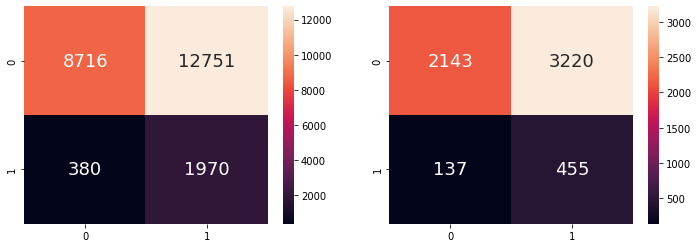

In [43]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_leaf_nodes=30,max_depth=15, class_weight="balanced",min_samples_split=900)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)
balanced_score  = balanced_accuracy_score(y_test, y_test_pred)
print(balanced_score)
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
results = confusion_matrix(y_test, y_test_pred)
sb.heatmap(results, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tpr = results[1][1]/results[1].sum()
tnr = results[0][0]/results[0].sum()
print("True positive rate: \t{}".format(tpr))
print("True negative rate: \t{}".format(tnr))

Although this model provided a decent true positive rate, the low true negative rate makes it impractical and suggests overfitting on popular songs

We make use of grid search to tune our hyperparameters for the decision tree.Limiting these parameters prevent our tree from overfitting, and allows our model to have higher accuracy on the test data. The parameters we have chosen are:
1. max_depth - limits the maximum depth that the tree can go
2. max_leaf_nodes - limits the number of leaf nodes the tree can have
3. min_sample_split - requires a branch to have a certain number of samples before splitting is allowed
4. max_features - restricts the number of features to be considered for splitting




As our popular to unpopular song ratio is imbalanced, we switched to a different scoring metric to evaluate the model's performance. The usage of "balanced accuracy" adjusts the class weights in proportion to their frequency in the dataset, and is a alternative solution to over/under sampling.

In [44]:
# Create a function to evaluate the performance of a grid search model
def print_grid_report(model):
  # print the best parameters found by gridsearch, and its score on the test set
  print(model.best_params_)
  y_test_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)
  print("Balanced accuracy score (test):" , model.score(X_test, y_test))

  #Plot confusion matrix for train and test data
  f, axes = plt.subplots(1, 2, figsize=(12, 4))
  sb.heatmap(confusion_matrix(y_train, y_train_pred),
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
  results = confusion_matrix(y_test, y_test_pred)
  sb.heatmap(results, 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
  
  #Calculate true and false positive rates
  results = confusion_matrix(y_test, y_test_pred)
  tpr = results[1][1]/results[1].sum()
  tnr = results[0][0]/results[0].sum()
  print("True positive rate: \t{}".format(tpr))
  print("True negative rate: \t{}".format(tnr))

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_split': 1000}
Balanced accuracy score (test): 0.5844454432523144
True positive rate: 	0.6503378378378378
True negative rate: 	0.518553048666791


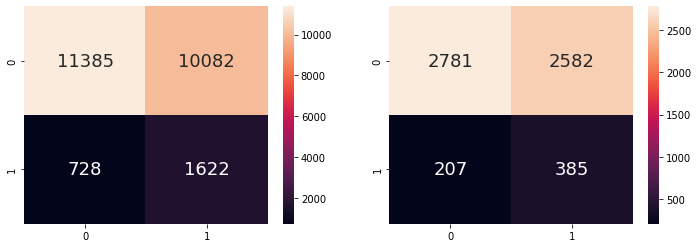

In [45]:
# Find the best parameter range to use
parameters = {"max_depth": [None,10,20,30,40,50], "max_leaf_nodes": [None,10,20,30,40,50], "class_weight":["balanced"], "min_samples_split":[2,50,500,1000,1500],
              "criterion":["gini", "entropy"],"max_features":[None,"sqrt", "log2"]}
grid = GridSearchCV(DecisionTreeClassifier(), parameters, refit = True, verbose = 3,n_jobs=-1,scoring="balanced_accuracy")
grid.fit(X_train, y_train)
 
print_grid_report(grid)

Using grid search, we have managed to reduce the number of false positives predicted


However, the overall balanced score for the decision tree model is relatively low(0.577), and cannot be considered reliable in predicting popular songs

##Random Forest

The next alternative we try is the random forest classifier. Random forest  fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

0.5959351109453664 0.625
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6069194272998278

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5988245172124266
True positive rate: 	0.625
True negative rate: 	0.5959351109453664


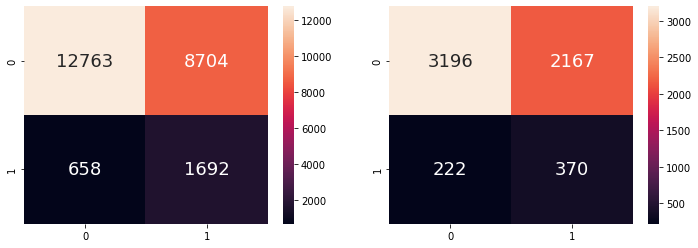

In [46]:
# Decision Tree using Train Data
dectree = RandomForestClassifier(max_depth=30, max_leaf_nodes=30, class_weight="balanced",n_estimators=400)  # create the decision tree object
dectree.fit(X_train, y_train.values.ravel())                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

results = confusion_matrix(y_test, y_test_pred)
tpr = results[1][1]/results[1].sum()
tnr = results[0][0]/results[0].sum()
print(tnr, tpr)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

sb.heatmap(results, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))

print("True positive rate: \t{}".format(tpr))
print("True negative rate: \t{}".format(tnr))

Similar to our decision tree, we run grid search to find the best parameters for the random forest model

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_split': 2, 'n_estimators': 400}
Balanced accuracy score (test): 0.6094420100689912
True positive rate: 	0.625
True negative rate: 	0.5938840201379825


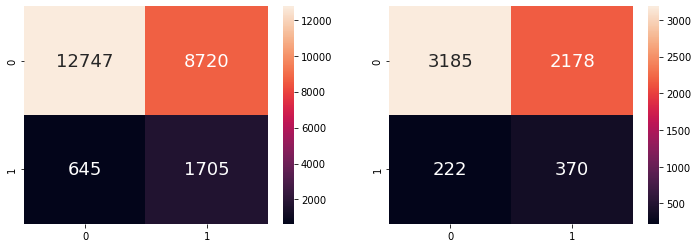

In [47]:
# Find the general best parameters 
parameters = {"max_depth": [10,20,30,40], "max_leaf_nodes": [30,40,50,60], "class_weight":["balanced"], "min_samples_split":[2],
              "criterion":["gini"],"max_features":["sqrt"], "n_estimators":[400]}
grid = GridSearchCV(RandomForestClassifier(), parameters, refit = True, verbose = 3,n_jobs=-1, scoring='balanced_accuracy')
grid.fit(X_train, y_train.values.ravel())

print_grid_report(grid)

## K nearest neighbours

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'leaf_size': 30, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

     Not pop       0.90      1.00      0.95      5363
         pop       0.19      0.01      0.02       592

    accuracy                           0.90      5955
   macro avg       0.55      0.50      0.48      5955
weighted avg       0.83      0.90      0.85      5955

0.5027367825591768
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5027367825591768

True positive rate: 	0.010135135135135136
True negative rate: 	0.9953384299832183


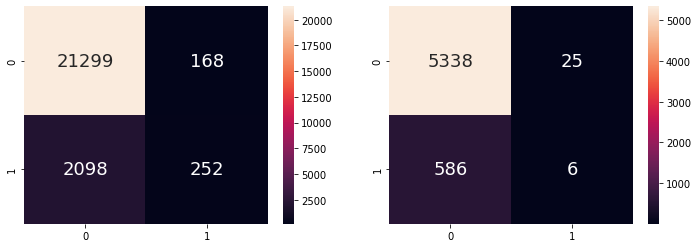

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Decision Tree using Train Data
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

# Predict Response corresponding to Predictors
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Grid search
parameters = {"n_neighbors": [10,20,30,40,50], "weights":["uniform", "distance"], "leaf_size":[30,40,50,60],
              "p":[1, 2]}
grid = GridSearchCV(KNeighborsClassifier(), parameters, refit = True, verbose = 3, n_jobs=-1, scoring='balanced_accuracy')
grid.fit(X_train, y_train.values.ravel())
 
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

   
# print classification report 
print(classification_report(y_test, grid_predictions))

accuracy = balanced_accuracy_score(y_test, grid_predictions)
print(accuracy)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", grid.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", grid.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

results = confusion_matrix(y_test, grid_predictions)
sb.heatmap(results, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tpr = results[1][1]/results[1].sum()
tnr = results[0][0]/results[0].sum()
print("True positive rate: \t{}".format(tpr))
print("True negative rate: \t{}".format(tnr))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


{'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Balanced accuracy score (test): 0.5127185268430839
True positive rate: 	0.04054054054054054
True negative rate: 	0.9848965131456274


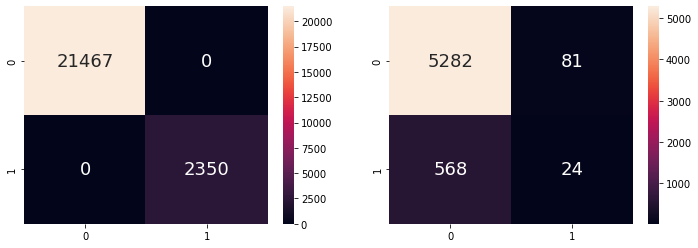

In [50]:
# Fine-tune the parameters for the best performance
parameters = {"n_neighbors": [i for i in range(5,15)], "weights":["distance"], "leaf_size":[30],
              "p":[2]}
grid = GridSearchCV(KNeighborsClassifier(), parameters, refit = True, verbose = 3,n_jobs=-1,scoring="balanced_accuracy")
grid.fit(X_train, y_train)
 
print_grid_report(grid)

## Logistic regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


{'class_weight': 'balanced', 'max_iter': 100, 'n_jobs': -1, 'solver': 'sag'}
              precision    recall  f1-score   support

     Not pop       0.93      0.59      0.72      5363
         pop       0.14      0.60      0.23       592

    accuracy                           0.59      5955
   macro avg       0.54      0.60      0.47      5955
weighted avg       0.85      0.59      0.67      5955

0.5964111895318776
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6175358615747675

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5964111895318776

True positive rate: 	0.6030405405405406
True negative rate: 	0.5897818385232146


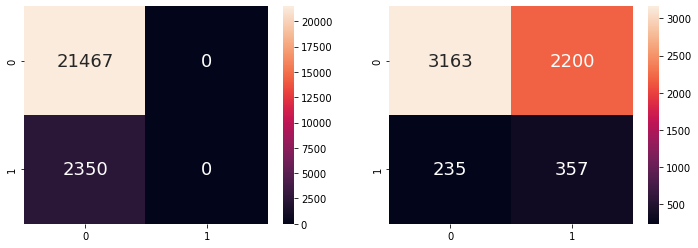

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Decision Tree using Train Data
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

# Predict Response corresponding to Predictors
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Grid search
parameters = {"solver":["sag", "saga"], "class_weight":["balanced"], "max_iter":[20,40,60,80,100],
              "n_jobs":[-1]}
grid = GridSearchCV(LogisticRegression(), parameters, refit = True, verbose = 3, n_jobs=-1, scoring='balanced_accuracy')
grid.fit(X_train, y_train.values.ravel())

 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 

   
# print classification report 
print(classification_report(y_test, grid_predictions))

accuracy = balanced_accuracy_score(y_test, grid_predictions)
print(accuracy)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", grid.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", grid.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

results = confusion_matrix(y_test, grid_predictions)
sb.heatmap(results, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tpr = results[1][1]/results[1].sum()
tnr = results[0][0]/results[0].sum()
print("True positive rate: \t{}".format(tpr))
print("True negative rate: \t{}".format(tnr))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


{'class_weight': 'balanced', 'max_iter': 67, 'n_jobs': -1, 'solver': 'sag'}
Balanced accuracy score (test): 0.595812744732426
True positive rate: 	0.5625
True negative rate: 	0.6291254894648518


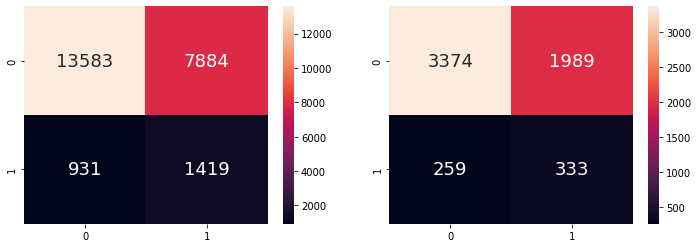

In [52]:
# Fine-tune the parameters for the best performance
parameters = {"solver": ["sag"], "class_weight": ["balanced"], "max_iter":[i for i in range(50,70)], "n_jobs":[-1]}
grid = GridSearchCV(LogisticRegression(), parameters, refit = True, verbose = 3,n_jobs=-1,scoring="balanced_accuracy")
grid.fit(X_train, y_train)
 
print_grid_report(grid)

## Gradient boosting

Fitting 5 folds for each of 105 candidates, totalling 525 fits
{'learning_rate': 1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 80}
              precision    recall  f1-score   support

     Not pop       0.90      0.96      0.93      5363
         pop       0.19      0.08      0.11       592

    accuracy                           0.88      5955
   macro avg       0.55      0.52      0.52      5955
weighted avg       0.83      0.88      0.85      5955

0.5210441538872455
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6667347408045401

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5210441538872455

True positive rate: 	0.0777027027027027
True negative rate: 	0.9643856050717882


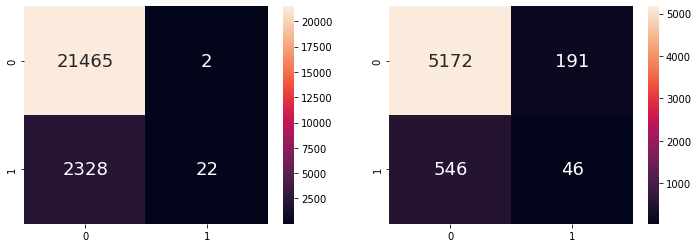

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix

# Scale the data
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

# Split the Dataset into Train and Test
# X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, y_train, test_size = 0.2)

# Decision Tree using Train Data
gbc = GradientBoostingClassifier()
gbc.fit(X_train_transformed,y_train)

# Predict Response corresponding to Predictors
y_train_pred = gbc.predict(X_train_transformed)
y_test_pred = gbc.predict(X_test_transformed)

# Grid search
parameters = {"n_estimators":[20,40,60,80,100], "learning_rate":[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1], "max_depth":[2,3,5],
              "min_samples_split":[100], "min_samples_leaf":[30], "max_features":["sqrt"]}
grid = GridSearchCV(GradientBoostingClassifier(), parameters, refit = True, verbose = 3, n_jobs=-1, scoring='balanced_accuracy')
grid.fit(X_train_transformed, y_train.values.ravel())

 
# print best parameter after tuning 
print(grid.best_params_)
grid_predictions = grid.predict(X_test_transformed)

   
# print classification report 
print(classification_report(y_test, grid_predictions))

accuracy = balanced_accuracy_score(y_test, grid_predictions)
print(accuracy)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", grid.score(X_train_transformed, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", grid.score(X_test_transformed, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

results = confusion_matrix(y_test, grid_predictions)
sb.heatmap(results, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tpr = results[1][1]/results[1].sum()
tnr = results[0][0]/results[0].sum()
print("True positive rate: \t{}".format(tpr))
print("True negative rate: \t{}".format(tnr))

In [ ]:
# Fine-tune the parameters(max_depth + min_samples_split) for the best performance
parameters = {"n_estimators":[80], "learning_rate":[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1], "max_depth":[i for i in range(5,15,2)],
              "min_samples_split":[j for j in range(100,500,100)], "min_samples_leaf":[30], "max_features":["sqrt"]}
grid = GridSearchCV(GradientBoostingClassifier(), parameters, refit = True, verbose = 3,n_jobs=-1,scoring="balanced_accuracy")
grid.fit(X_train_transformed, y_train.values.ravel())
 
print_grid_report(grid)